# Merge
    - 08/04 수 : 새파일 시작

### 1. input 파일
    - backsub 이미지 (640x480, .jpg)
    - backsub 이미지의 box 중심,길이 데이터 (.txt)
    
### 2. 구현방식
    - 4~5개의 틀을 만들고
    - 해당 틀에 들어가는 n개의 이미지를 선택하여 조합 생성
    - ex. 위2개/아래3개 모양의 틀을 1번, 위2개/중간2개/아래2개 모양의 틀을 2번이라 할 경우,
      1번틀에 들어가는 이미지 5개를 선택해 이미지 1000개 생성,
      2번틀에 들어가는 이미지 6개를 선택해 이미지 1000개 생성
      이런식으로 이미지 조합 여러개 생성 가능
      
### 3. output 파일
    - 640x480의 새로운 조합 이미지 (.jpg)
    - 해당 이미지의 box 데이터 (.txt)
    
    
### 틀 (frame)
    1. 상3하2
      parameters :
          a. 열 사이 간격
          b. 옆 객체와의 간격 

In [146]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
from PIL import ImageDraw
import numpy as np
import os

#%matplotlib inline
plt.rcParams['figure.figsize'] = (3, 4)

# DRAW BOX - https://wikidocs.net/73720
#   img : Image.open(*)으로 load한 이미지
#   c : list of int
def pil_draw_rect(img, c):
    draw = ImageDraw.Draw(img)
    draw.rectangle(((c[0], c[1]), (c[2], c[3])), outline=(100, 255, 255), width=4)
    return img

# CALCULATE THE COORDINATES OF BOX
#   line : single string
def bx_coord(line):
    w, h = 640, 480
    n_s = line.split()
    n = [float(i) for i in n_s]
    box_f = (w*(n[1]-n[3]/2), h*(n[2]-n[4]/2), w*(n[1]+n[3]/2), h*(n[2]+n[4]/2))
    box = [int(i) for i in box_f]
    return box

# COMBINATION FOR FRAME_1, return x12 sets of x5 numbers
#   n : type of combination, default is 0 (not using 1~4)
def combi(n):
    cbs = [[],[],[],[],[]]
    cbs[0] = [np.random.randint(1,12) for x in range(5)] 
    #print(cbs[0])
    cbs[1] = [1,2,3,4,5]
    cbs[2] = [1,3,5,7,9]
    cbs[3] = [1,4,7,10,12]
    cbs[4] = [1,6,8,9,11]
    
    w, h = 5, 12;
    res = [[0 for x in range(w)] for y in range(h)] 
    
    for k in range(0,12):
        for i in range(0,5):
            res[k][(i-n)%5] = ((cbs[n][i]-1)*5+i+k*5+1)%60
            
    return res

# CREATE PATH COMBINATION OF IMAGE, return x12 sets of x5 paths
def target_path():
    folder_list = sorted(os.listdir("/home/ai_competition6/3.backsub_images_100"))
    paths = ["/home/ai_competition6/3.backsub_images_100/"+ folder  \
             for folder in folder_list if os.path.isdir(os.path.join("/home/ai_competition6/3.backsub_images_100/",folder))]
    
    target = paths
    for i in range(0,60):
        files = sorted(os.listdir(paths[i]))
        l = len(files)
        j = np.random.randint(0,l//2)
        
        target[i] = target[i] + "/" + files[2*j]
        '''
        f = open(target[i][:-3]+"txt", "r")
        line = f.readlines()[0]
        while len(line.split())==0 : 
            j = np.random.randint(0,l//2)
            target[i] = target[i] + "/" + files[2*j]
            f = open(target[i][:-3]+"txt", "r")
            line = f.readlines()
        '''
        #print(target[i])

    w, h = 5, 12;
    c_target = [["" for x in range(w)] for y in range(h)] 
    comb = combi(0)

    for i in range(12):
        for j in range(5):
            c_target[i][j] = target[comb[i][j]]
            
    return c_target

def print_12x5(c_target):
    for i in range(12):
        for j in range(5):
            print(c_target[i][j])
        print("--------------------------------------------------")

    
# RETURN MERGED IMAGE USING FRAME 1 (U3D2)
#   img_paths : list of string (paths of images)
#   typ : integer (type of merge a.k.a number of images for merge)
#   var_1 : float (variable for different horizontal-overlap)
#   var_2 : float (variable for different vertical-overlap)
def merge(img_paths, typ, var_1, var_2, iter_n):
    
    typ = 5
    
    labels = []
    for i in range(12):
        try:
            # create new empty image
            labels = []
            size = (640, 480)
            name = [ 0 for x in range(typ)]
            rand_rgb_var = 220
            rand_rgb = (np.random.randint(rand_rgb_var,255), np.random.randint(rand_rgb_var,255) ,np.random.randint(rand_rgb_var,255))
            new_image = Image.new('RGB', size, rand_rgb)

            imgs_size = [ (0,0) for x in range(typ)]
            box_size = [[0 for x in range(2)] for y in range(typ)] 
            for j in range(typ):
                with Image.open(img_paths[i][j]) as img:
                    imgs_size[j] = img.size

            crops = [Image.new('RGBA', (10,10), (255,255,255,0)) for x in range(typ)]

            for j in range(typ):
                # open iamge and convert to RGBA
                img = Image.open(img_paths[i][j])
                img = img.convert("RGBA")
                datas = img.getdata()

                # make transparent - https://studyforus.com/innisfree/594134
                newData = []
                cutOff = 1
                for item in datas:
                    if item[0] <= cutOff and item[1] <= cutOff and item[2] <= cutOff:
                        newData.append((255, 255, 255, 0))
                    else:
                        newData.append(item)
                img.putdata(newData)

                f = open(img_paths[i][j][:-3]+"txt", "r")
                line = f.readlines()
                w, h = imgs_size[j]
                n_s = line[0].split()
                name[j] = int(n_s[0])
                f.close()

                n = [float(i) for i in n_s]
                box_f = (w*(n[1]-n[3]/2), h*(n[2]-n[4]/2), w*(n[1]+n[3]/2), h*(n[2]+n[4]/2))
                box = [int(i) for i in box_f]

                box_size[j][0] = int(w*n[3])
                box_size[j][1] = int(h*n[4])

                # paste test - you should type 'mask' for background transparency
                #   https://stackoverflow.com/questions/38627870/how-to-paste-a-png-image-with-transparency-to-another-image-in-pil-without-white/38629258
                #temp = Image.new('RGBA', (400,400), (105,255,255,255))
                #temp_crop = img.crop(box)
                #temp.paste(temp_crop, (0,0), mask=temp_crop) 
                crops[j] = img.crop(box)

            #plt.figure(figsize=(16, 18))
            for j in range(typ):
                resize_wh = (0,0)
                bx = box_size[j][0]
                by = box_size[j][1]
                if bx>by : resize_wh = (200 , int(200*(by/bx)) )
                else : resize_wh = (int(200*(bx/by)), 200 )
                box_size[j] = resize_wh
                resized = crops[j].resize(resize_wh)

                '''
                plt.subplot(1,typ,j+1)
                plt.imshow(resized)
                '''

                # set frame
                coord = frame(typ,var_1,var_2, box_size)
                new_image.paste(resized, coord[j], mask=resized) 

                # make label
                t_cen_x = (coord[j][0] + resize_wh[0]/2)/size[0]
                t_cen_y = (coord[j][1] + resize_wh[1]/2)/size[1]
                t_box_w = resize_wh[0]/size[0]
                t_box_h = resize_wh[1]/size[1]
                label = [name[j], t_cen_x, t_cen_y, t_box_w, t_box_h]
                label = map(str, label)
                labels.append(' '.join(label))
                new_label = '\n'.join(labels)
        
        
            i_folder = '{0:04d}'.format(iter_n)
            i_str = '{0:04d}'.format(iter_n)+ '_'+ '{0:02d}'.format(i)

            if not os.path.exists('/home/ai_competition6/4.merge/'+ i_folder):
                os.makedirs('/home/ai_competition6/4.merge/'+ i_folder)

            with open('/home/ai_competition6/4.merge/'+ i_folder + '/'+ i_str + '.txt', 'w') as file:
                file.write(new_label)
            new_image.save('/home/ai_competition6/4.merge/' + i_folder + '/' + i_str +'.jpg')
            
        except : 
            print('  except at '+ str(iter_n) + ',' + str(i) )
            continue

        
        '''    
        plt.show()
        plt.figure(figsize=(40, 30))
        plt.imshow(new_image)
        print("----------------------------------")
        print(new_label)
        print("----------------------------------")
        print(type(new_label))
        box_new_image = new_image.copy()
        ll = new_label.split("\n")
        for l in ll:
            print(l[0])
            box_new_image = pil_draw_rect(box_new_image, bx_coord(l))
        plt.figure(figsize=(40, 30))
        plt.imshow(box_new_image)
        '''
        
        #paste cropped image to empty image
        #new_image.paste(cropped)
        
        
# RETURN MERGED IMAGE USING FRAME 1 (U3D2)
#   img_paths : list of string (paths of images)
def frame(typ, wx, wy, box_size):
    
    w, h = 2, typ
    coord =  [[0 for x in range(w)] for y in range(h)] 
    next_x = 30
    next_y = 100
    
    if typ == 5:
        for j in range(3):
            coord[j][0] = int(next_x)
            coord[j][1] = int(next_y)
            next_x = next_x + box_size[j][0]/wx
            next_y = next_y + (box_size[j][1]) - (box_size[j+1][1])
        for j in range(3,4):
            a = 0
            if box_size[j][0] > box_size[j][1]+100 :
                a = 100

            next_x = 30 + box_size[0][0]/2
            next_y = 100 + box_size[0][1]/wy + a
            coord[j][0] = int(next_x)
            coord[j][1] = int(next_y)
        for j in range(4,5):
            coord[j][0] = int(next_x + box_size[j-1][0]/wx)
            coord[j][1] = int(next_y + (box_size[j-1][1]) - (box_size[j][1]))
    
    #for l in coord:
    #    print(l)
    
    return coord

a = int(input('start : '))
b = int(input('end : '))
for i in range(a,b):
    print(i)
    merge(target_path(), 5, 1.4, 1.4, i)

In [147]:
#print_12x5(target_path())
merge(target_path(), 5, 1.4, 1.4, 1)
merge(target_path(), 5, 1.4, 1.4, 2)

In [77]:
img = Image.open("/home/ai_competition6/3.backsub_images_100/00.aunt_jemima_original_syrup/aunt_jemima_original_syrup_2306.jpg")

# create new empty image
size = (640, 480)
new_image = Image.new('RGB', size, (255,255,255))

# cut image along the anchor box
f = open("/home/ai_competition6/3.backsub_images_100/00.aunt_jemima_original_syrup/aunt_jemima_original_syrup_2306.txt", "r")
line = f.readlines()
w, h = img.size
n_s = line[0].split()
n = [float(i) for i in n_s]
box_f = (w*(n[1]-n[3]/2), h*(n[2]-n[4]/2), w*(n[1]+n[3]/2), h*(n[2]+n[4]/2))
box = [int(i) for i in box_f]
cropped = img.crop(box)
print(h, w)
print(box)

#paste cropped image to empty image
new_image.paste(cropped)
new_image.show()


480 640
[269, 69, 396, 309]


In [78]:
ls

1.competition_trainset/             merge-BW.ipynb
11819_darknet/                      merge-BW2.ipynb
16835_darknet/                      merge.ipynb
2.testset/                          merge_data/
3.backsub_images_100/               names.txt
4.merge/                            open_notebook.sh*
Anaconda3-2021.05-Linux-x86_64.sh*  test.txt*
Makefile                            train.txt
anaconda3/                          wanna.py
baseline/                           wanna_know_class_of_folder1.ipynb
examples.desktop


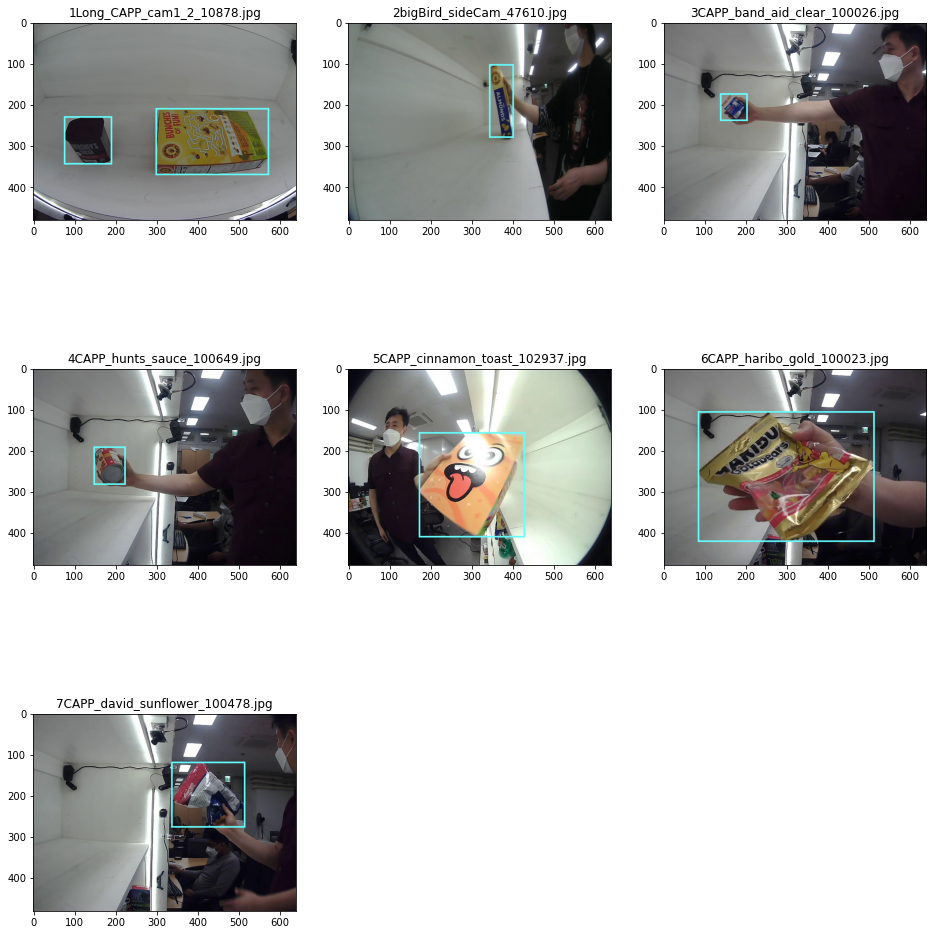

1 번째 dir의 caption
5 0.20859375 0.5947916666666667 0.1828125 0.24375
 6 0.68125 0.6010416666666667 0.43125 0.33958333333333335
--------------------
2 번째 dir의 caption
7 0.5828125 0.3958333333333333 0.09375 0.37083333333333335
--------------------
3 번째 dir의 caption
1 0.26484375 0.4270833333333333 0.1046875 0.1375
--------------------
4 번째 dir의 caption
8 0.290625 0.4947916666666667 0.121875 0.19375
--------------------
5 번째 dir의 caption
19 0.47109375 0.5927083333333333 0.4046875 0.53125
--------------------
6 번째 dir의 caption
22 0.4640625 0.55 0.671875 0.6625
--------------------
7 번째 dir의 caption
55 0.665625 0.4083333333333333 0.28125 0.3333333333333333
--------------------


In [64]:
plt.figure(figsize=(16, 18))
texts = []
for p in enumerate(paths):
    idx = np.random.randint(length[p[0]])
    file_list = sorted(os.listdir(p[1]))
    plt.subplot(3, 3, 3*(p[0]//3)+(p[0]%3)+1)
    plt.title(str(p[0]+1)+ file_list[idx*2])
    
    img = Image.open(p[1]+file_list[idx*2])
    #img = imread(p[1]+file_list[idx*2])
    
    f = open(p[1]+file_list[idx*2+1], "r")
    text = f.readlines()
    texts.append(text)
    
    for l in text:
        img = pil_draw_rect(img, bx_coord(l))
        
    plt.imshow(img)
    
plt.show()

for t in enumerate(texts):
    print(t[0]+1, '번째 dir의 caption')
    print(*t[1])
    print('--------------------')

In [6]:
test_paths = "/home/ai_competition6/2.testset/"
test_file_list = sorted(os.listdir(test_paths))
print('number of objects in testset is', len(file_test_file_listlist)//2)
n = len(test_file_list)//2

number of objects in testset is 19779


<Figure size 216x288 with 0 Axes>

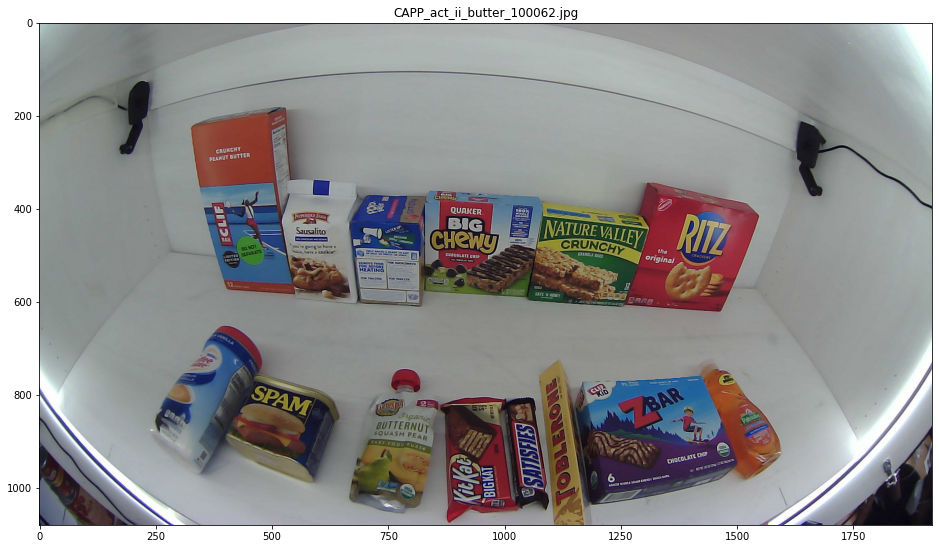

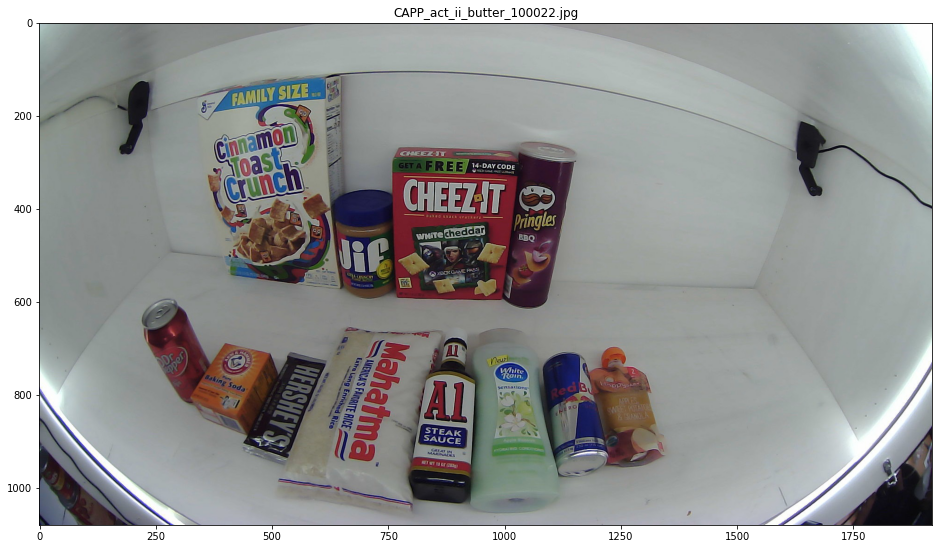

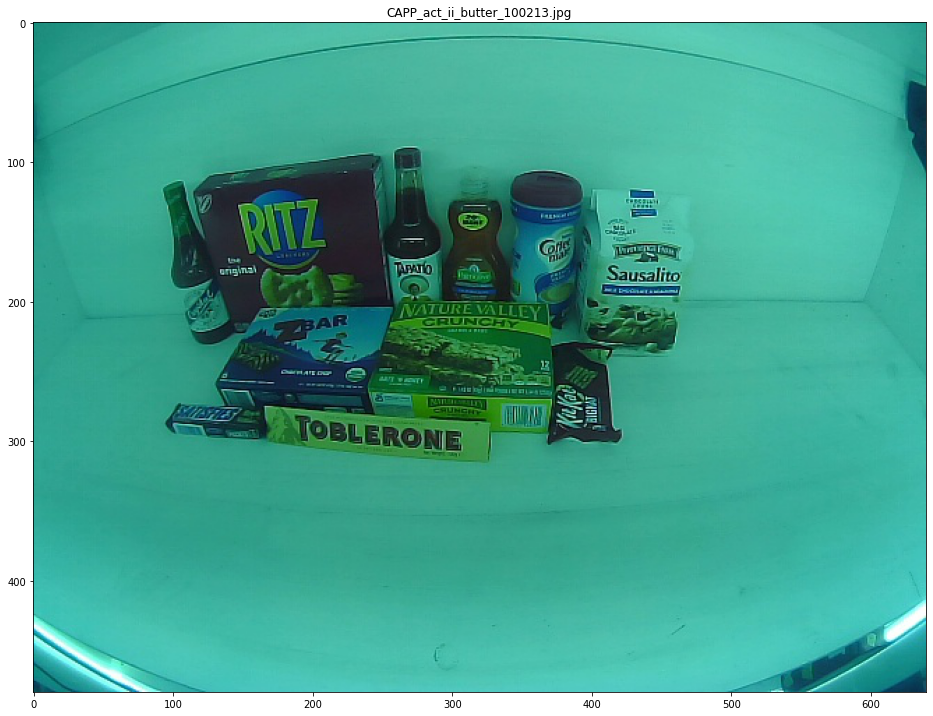

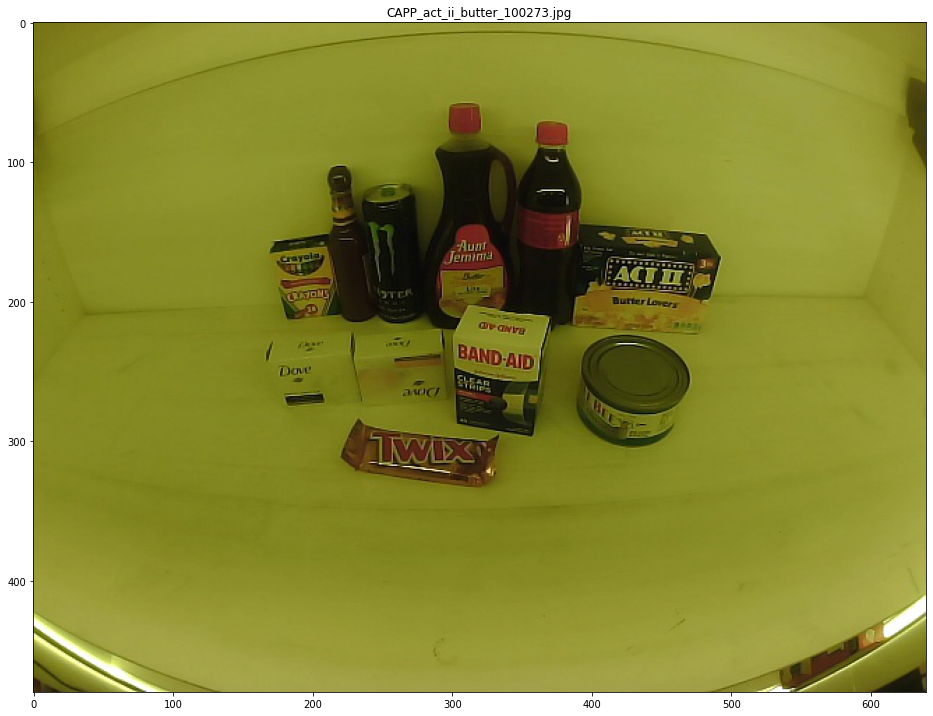

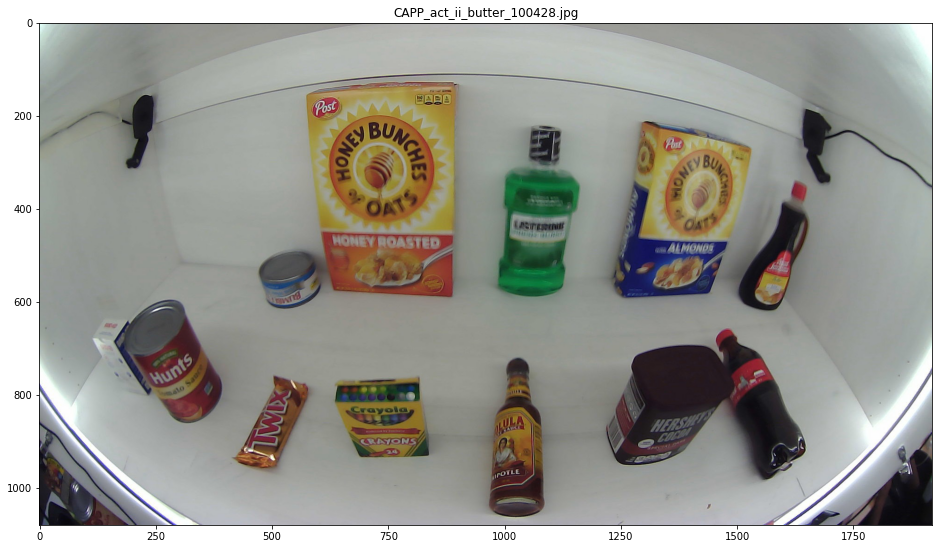

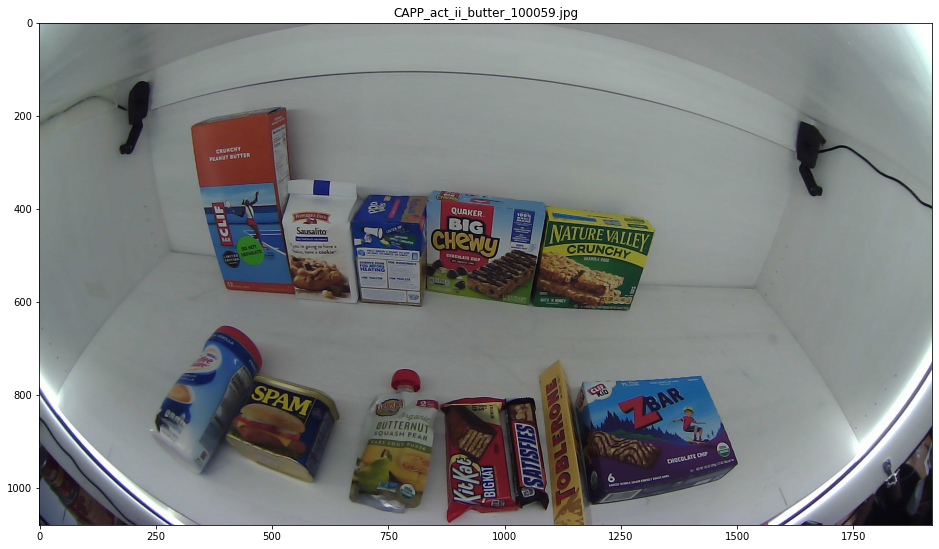

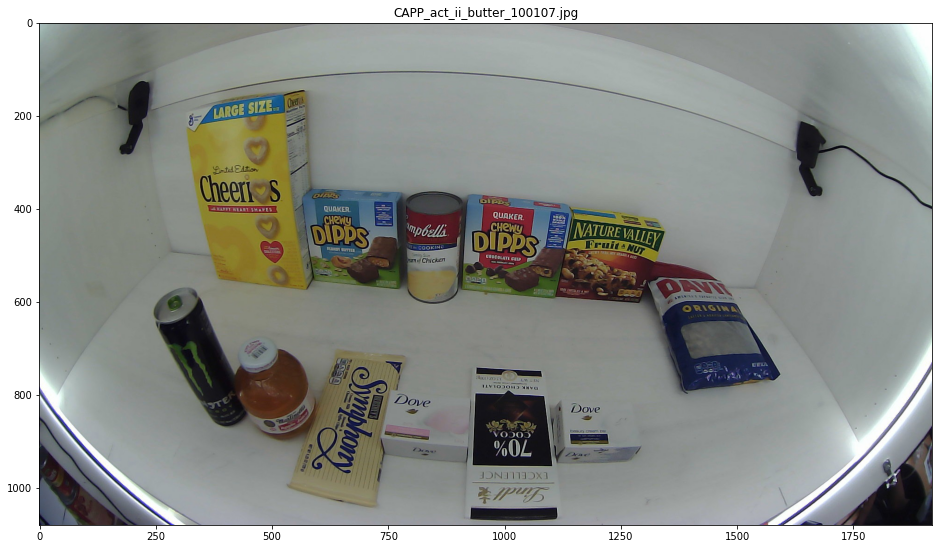

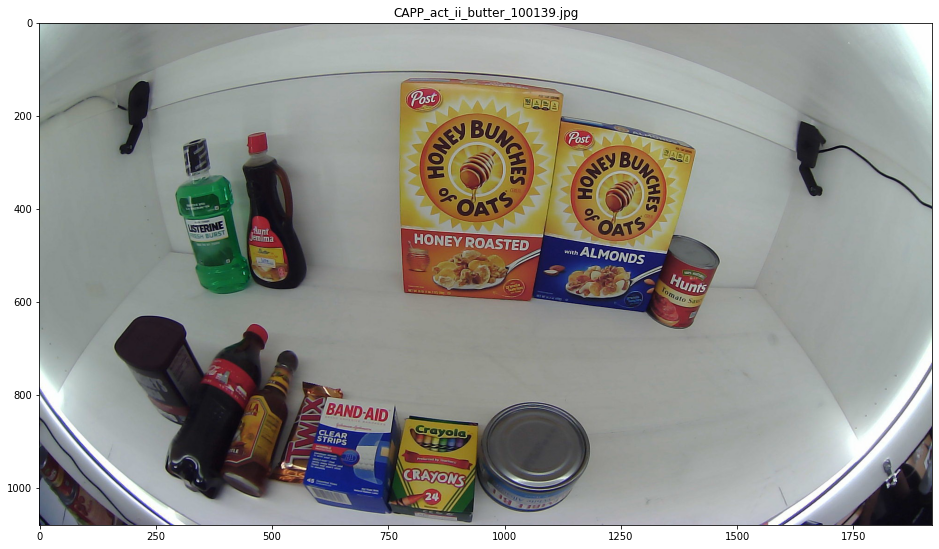

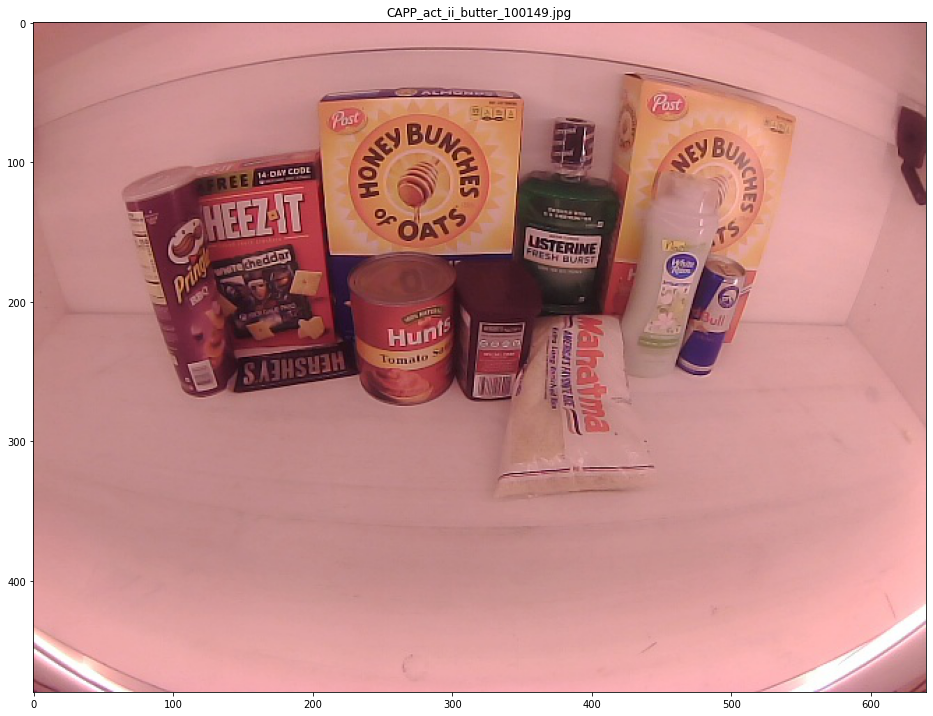

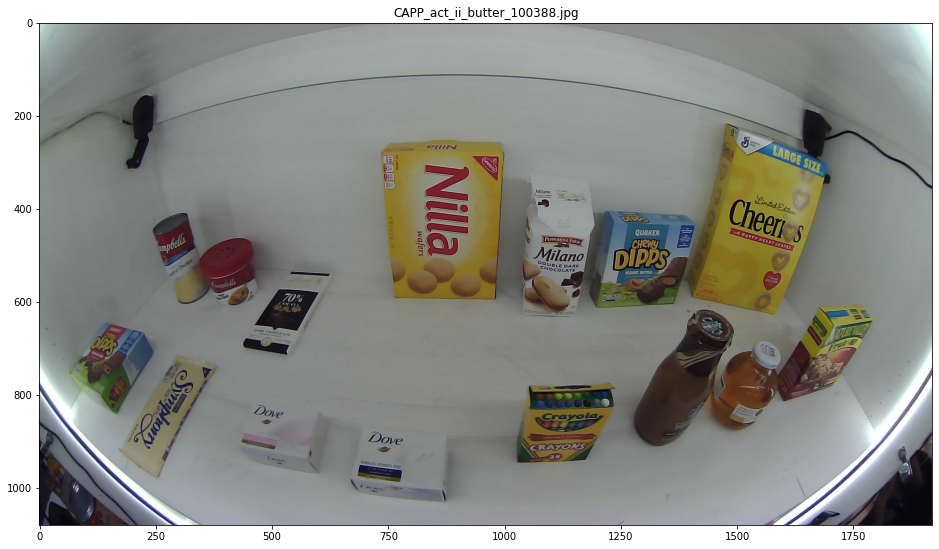

'\nf = open(test_paths + test_file_list[idx*2+1], "r")\ntext = f.readlines()\nf.close()\nprint(*text)\n'

In [217]:
plt.figure(figsize=(3, 4))

for _ in range(10):
    idx = np.random.randint(n)
    plt.figure(figsize=(16, 18))
    img = imread(test_paths + test_file_list[idx*2])
    plt.imshow(img)
    plt.title(file_list[idx*2])
plt.show()
'''
f = open(test_paths + test_file_list[idx*2+1], "r")
text = f.readlines()
f.close()
print(*text)
'''